mount the google drive

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


import libraries

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

فارسی سازی دیتای کانون

In [11]:
df = pd.read_excel('total_kanoon_1401.xlsx')
df = df.replace({"ك": "ک", "ي": "ی", "ه": "ه", "ة": "ه", "أ": "ا", "إ": "ا", "ؤ": "و", "ئ": "ی"}, regex=True)
df.to_excel('total_kanoon_1401.xlsx')

بررسی منطقه ۱ و ۲ و ۳ برای تمامی دانشگاه ها و اضافه کردن منطقه ی ناموجود جهت پر کردن رتبه در منطقه ی آن<br>نکته : پس از ران کردن این کد یه ستون اضافی تشکیل میشه که باید اونو دستی حذفش کنیم

In [12]:
import pandas as pd

# بارگذاری فایل اکسل
file_path = 'total_kanoon_1401.xlsx'
df = pd.read_excel(file_path)

# تغییر نام ستون 'دانشگاه ' به 'دانشگاه'
df.rename(columns={'دانشگاه ': 'دانشگاه'}, inplace=True)

# گروه‌بندی داده‌ها بر اساس ستون‌های مشخص شده
grouped = df.groupby(['نوع دوره', 'دانشگاه', 'reshte_name', 'group_name'])

# لیست خالی برای ذخیره ردیف‌های جدید
new_rows = []

# بررسی هر گروه و افزودن ردیف‌های جدید در صورت نیاز
for name, group in grouped:
    existing_regions = group['region_quota'].values
    for region in ['منطقه 1', 'منطقه 2', 'منطقه 3']:
        if region not in existing_regions:
            # ایجاد ردیف جدید با منطقه مفقود و ستون‌های رتبه خالی
            new_row = {col: None for col in df.columns}
            new_row.update({
                'region_quota': region,
                'نوع دوره': name[0],
                'دانشگاه': name[1],
                'reshte_name': name[2],
                'group_name': name[3]
            })
            new_rows.append(new_row)

# افزودن ردیف‌های جدید به دیتافریم اصلی
updated_df = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)

# ذخیره دیتافریم به فایل اکسل جدید
output_file_path = 'add_region.xlsx'
updated_df.to_excel(output_file_path, index=False)

print(f'Updated file saved to {output_file_path}')


Updated file saved to add_region.xlsx


پیدا کردن ماکسیمم رتبه برای هر منطقه برای هر رکورد و نگه داشتن ماکسیمم رتبه ی منطقه ی هر دانشگاه و حذف بقیه ی رکورد ها         

In [13]:
# Load the Excel file
file_path = 'add_region.xlsx'
df = pd.read_excel(file_path, sheet_name='Sheet1')

# Drop duplicates based on the specified columns, keeping the row with the highest national_rank
df_cleaned = df.sort_values('national_rank', ascending=False).drop_duplicates(subset=['region_quota', 'نوع دوره', 'دانشگاه', 'reshte_name', 'group_name'], keep='first')

# Save the cleaned data to a new Excel file
output_file_path = 'max_data.xlsx'
df_cleaned.to_excel(output_file_path, index=False)

print(f"Cleaned data saved to {output_file_path}")


Cleaned data saved to max_data.xlsx


پر کردن رتبه ی کشوری رکورد های جدیدی که اضافه شده اند.  نحوه ی پر کردن به این صورت است که ماکسیمم رتبه بین منطقه های مختلف آن رکورد رو در نظر میگیریم

In [14]:
# Load the dataset
file_path = 'max_data.xlsx'  # تغییر دهید به مسیر فایل خود
data = pd.read_excel(file_path)

# Function to fill missing national_rank values with the maximum of available national_rank values for the same university, reshte_name, and group_name
def fill_missing_national_rank(df):
    # Identify rows where national_rank is missing
    missing_mask = df['national_rank'].isnull()

    # Iterate over rows with missing national_rank
    for index, row in df[missing_mask].iterrows():
        # Filter rows with the same university, reshte_name, and group_name and non-missing national_rank
        similar_rows = df[(df['دانشگاه'] == row['دانشگاه']) &
                          (df['reshte_name'] == row['reshte_name']) &
                          (df['group_name'] == row['group_name']) &
                          (~df['national_rank'].isnull())]

        if not similar_rows.empty:
            # Find the maximum national_rank
            max_national_rank = similar_rows['national_rank'].max()
            # Fill the missing national_rank with the maximum national_rank
            df.at[index, 'national_rank'] = max_national_rank

    return df

# Apply the function to the dataset
filled_data = fill_missing_national_rank(data)

# Save the filled data to a new Excel file
output_file_path = 'filled_national_rank_data.xlsx'  # تغییر دهید به نام فایل خروجی دلخواه
filled_data.to_excel(output_file_path, index=False)

print("Data has been processed and saved to:", output_file_path)


Data has been processed and saved to: filled_national_rank_data.xlsx


### کامل کردن دیتاست

حذف ستون های اضافی ای دیتای کانون و کگل و نگه داشتن ستون های
<span style="color:darkblue; font-weight:bold;">رتبه ی کشوری</span> و
<span style="color:darkblue; font-weight:bold;">رتبه در منطقه</span> و
<span style="color:darkblue; font-weight:bold;">نوع منطقه</span> و
<span style="color:darkblue; font-weight:bold;">گروه آزمایشی</span>.
و حذف سهمیه های ایثار گران و خانواده ی شهدا و ذخیره سازی در فایل filtred_comb_dataset

نوشتن مدل ماشین لرنینگ رندم فارست

In [15]:
# Load the dataset
file_path = 'filtred_comb_dataset.xlsx'
data = pd.read_excel(file_path)

# Preprocess the data
# Encode categorical variables
label_encoder_region = LabelEncoder()
label_encoder_group = LabelEncoder()

data['region_quota_encoded'] = label_encoder_region.fit_transform(data['region_quota'])
data['group_name_encoded'] = label_encoder_group.fit_transform(data['group_name'])

# Prepare features and target variable
X = data[['national_rank', 'region_quota_encoded', 'group_name_encoded']]
y = data['quota_rank']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model using Random Forest Regressor
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

# Evaluate the model
y_pred_rf = model_rf.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2 = r2_score(y_test, y_pred_rf)

print(f'Mean Absolute Error (MAE): {mae_rf}')
print(f'Root Mean Squared Error (RMSE): {rmse_rf}')
print(f'r2 socore is : {r2}')

# Display the test set along with the actual and predicted values
test_results = X_test.copy()
test_results['actual_quota_rank'] = y_test.values
test_results['predicted_quota_rank'] = y_pred_rf

print(test_results.head())

# Save the model and encoders
joblib.dump(model_rf, 'random_forest_model.pkl')
joblib.dump(label_encoder_region, 'label_encoder_region.pkl')
joblib.dump(label_encoder_group, 'label_encoder_group.pkl')

print("Model and encoders saved successfully.")

# Function to predict quota_rank for new inputs
def predict_quota_rank(national_rank, region_quota, group_name):
    # Load the encoders and model
    model_rf = joblib.load('random_forest_model.pkl')
    label_encoder_region = joblib.load('label_encoder_region.pkl')
    label_encoder_group = joblib.load('label_encoder_group.pkl')

    region_quota_encoded = label_encoder_region.transform([region_quota])[0]
    group_name_encoded = label_encoder_group.transform([group_name])[0]
    input_data = pd.DataFrame([[national_rank, region_quota_encoded, group_name_encoded]],
                              columns=['national_rank', 'region_quota_encoded', 'group_name_encoded'])
    prediction = model_rf.predict(input_data)
    return prediction[0]

Mean Absolute Error (MAE): 63.57712831707832
Root Mean Squared Error (RMSE): 238.9290279973793
r2 socore is : 0.9991262418298967
       national_rank  region_quota_encoded  group_name_encoded  \
56676            283                     0                   1   
88660          91273                     2                   1   
76752          23753                     2                   1   
66601            179                     0                   1   
20473           1149                     1                   0   

       actual_quota_rank  predicted_quota_rank  
56676                 94            108.985000  
88660              31830          31819.520000  
76752               7050           7049.490000  
66601                 70             69.236167  
20473                447            400.262000  
Model and encoders saved successfully.


تست تکی تکی

In [16]:
# Example prediction
print(predict_quota_rank(200000, 'منطقه 2', 'تجربی'))

77343.47


نمایش نموداری

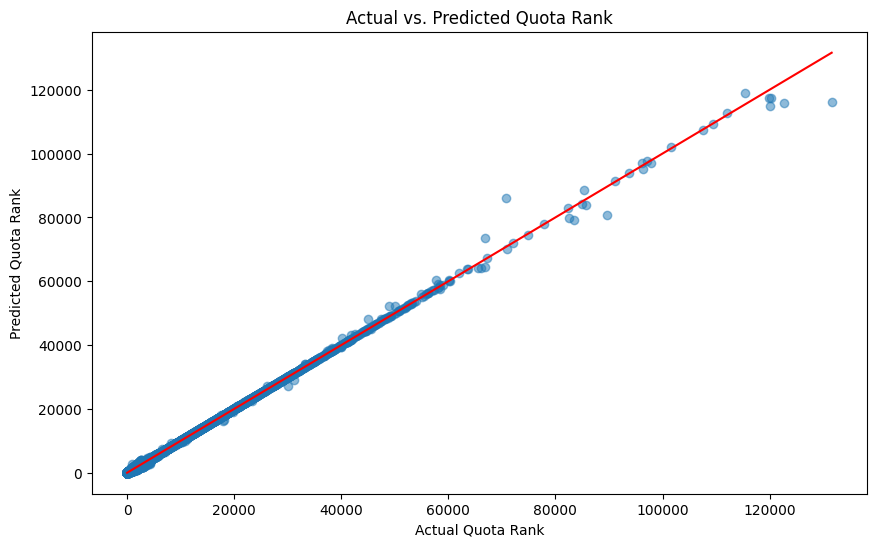

<Figure size 640x480 with 0 Axes>

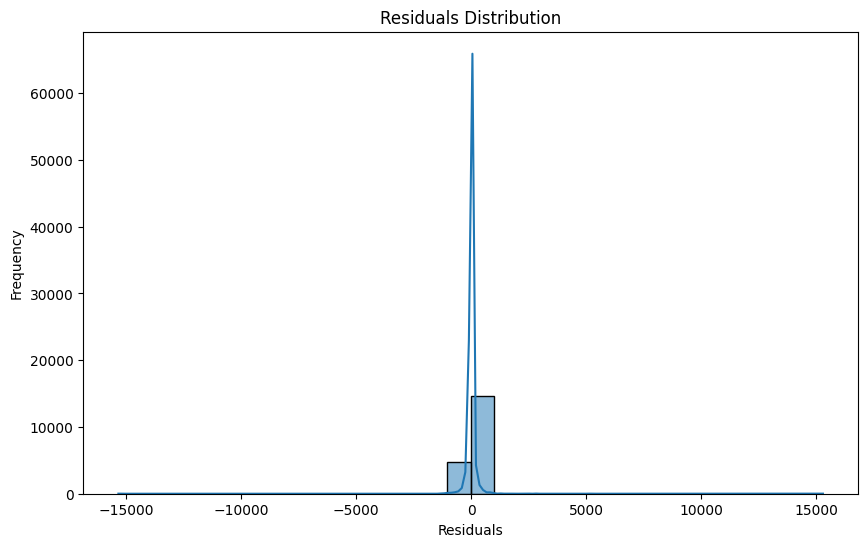

In [17]:
# Visualize model performance
# Scatter plot of Actual vs. Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Line of perfect prediction
plt.xlabel('Actual Quota Rank')
plt.ylabel('Predicted Quota Rank')
plt.title('Actual vs. Predicted Quota Rank')
plt.show()
plt.savefig('actual_vs_predicted_quota_rank.png')  # Save the plot as an image


# Residual plot
residuals = y_test - y_pred_rf
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.show()

استفاده از مدل جهت پر کردن مقادیر خالی با استفاده از پیش بینی ماشین لرنینگ

In [18]:
# Load the dataset
file_path = 'filled_national_rank_data.xlsx'  # Path to your dataset
data = pd.read_excel(file_path)

# Load the saved model and encoders
model_rf = joblib.load('random_forest_model.pkl')
label_encoder_region = joblib.load('label_encoder_region.pkl')
label_encoder_group = joblib.load('label_encoder_group.pkl')

# Check for records with NaN quota_rank
missing_quota_rank_mask = data['quota_rank'].isnull()

# Prepare features for the missing quota_rank records
missing_data = data[missing_quota_rank_mask].copy()
missing_data['region_quota_encoded'] = label_encoder_region.transform(missing_data['region_quota'])
missing_data['group_name_encoded'] = label_encoder_group.transform(missing_data['group_name'])

# Select the features required for prediction
X_missing = missing_data[['national_rank', 'region_quota_encoded', 'group_name_encoded']]

# Predict quota_rank for records with NaN values
predicted_quota_rank = model_rf.predict(X_missing)

# Fill the missing quota_rank values with the predicted values
data.loc[missing_quota_rank_mask, 'quota_rank'] = predicted_quota_rank

# Save the updated data to a new Excel file
output_file_path = 'predicted_quota_rank_data.xlsx'  # Path to save the updated dataset
data.to_excel(output_file_path, index=False)

print(f"Updated data saved to {output_file_path}")


Updated data saved to predicted_quota_rank_data.xlsx
